In [1]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Load the MNIST dataset
mnist = fetch_openml(name     = 'mnist_784', 
                     data_home= r'D:\AI-DATASETS\keras\datasets\sklearn',
                     #parser   = 'auto'
                    )

In [3]:
x_train = mnist.data

In [5]:
x_train.shape

(70000, 784)

In [10]:
# Define the dimensions of the input data
input_dim = x_train.shape[1]  # Number of features

In [11]:
# Normalize the input data
scaler  = MinMaxScaler()
x_train = scaler.fit_transform(x_train)

In [12]:
# Define the size of the encoded representation (bottleneck layer)
encoding_dim = 32

In [13]:
# Define the parameters for training
learning_rate = 0.1
num_epochs    = 10
batch_size    = 32

In [14]:
# Define the weight matrices for the encoder and decoder
W1 = np.random.randn(input_dim, encoding_dim) * 0.01
W2 = np.random.randn(encoding_dim, input_dim) * 0.01

In [15]:
# Define the bias vectors for the encoder and decoder
b1 = np.zeros((1, encoding_dim))
b2 = np.zeros((1, input_dim))

In [16]:
# Define the activation function (sigmoid)
# this errors out, RuntimeWarning: overflow encountered in exp
# def sigmoid(x):
#     return 1 / (1 + np.exp(-x))

# use gradient clipping
# option 1
def sigmoid(x):
    clipped_x = np.clip(x, -500, 500)  # Clip x to prevent overflow/underflow
    return 1 / (1 + np.exp(-clipped_x))

# option 2
# from scipy.special import expit

# # Replace the sigmoid function with expit
# def sigmoid(x):
#     return expit(x)

# Define the derivative of the activation function
def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

In [17]:
%%time
# Train the autoencoder
for epoch in range(num_epochs):
    
    # Shuffle the input data
    np.random.shuffle(x_train)
    
    # Split the input data into batches
    num_batches = len(x_train) // batch_size
    batches      = np.array_split(x_train, num_batches)
    
    # Iterate over each batch
    for batch in batches:
        # Forward propagation
        hidden = sigmoid(np.dot(batch, W1) + b1)
        output = sigmoid(np.dot(hidden, W2) + b2)
        
        # Backpropagation
        output_error = batch - output
        output_delta = output_error * sigmoid_derivative(output)
        hidden_error = np.dot(output_delta, W2.T)
        hidden_delta = hidden_error * sigmoid_derivative(hidden)
        
        # Update weights and biases
        W2 += learning_rate * np.dot(hidden.T, output_delta)
        b2 += learning_rate * np.sum(output_delta, axis=0, keepdims=True)
        W1 += learning_rate * np.dot(batch.T, hidden_delta)
        b1 += learning_rate * np.sum(hidden_delta, axis=0, keepdims=True)

CPU times: total: 57.2 s
Wall time: 1min 20s


#### reconstruction

In [19]:
# Select 10 random samples for reconstruction
num_samples    = 10
sample_indices = np.random.choice(len(x_train), num_samples, replace=False)

In [20]:
x_samples = x_train[sample_indices]

In [21]:
x_samples

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [22]:
# Use the trained autoencoder to reconstruct the input data samples
hidden        = sigmoid(np.dot(x_samples, W1) + b1)
reconstructed = sigmoid(np.dot(hidden, W2) + b2)

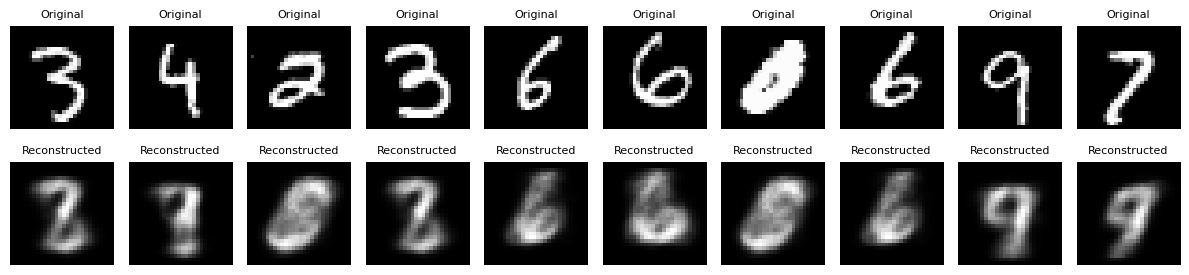

In [23]:
# Print the original and reconstructed samples
import matplotlib.pyplot as plt

# Display the original and reconstructed samples
fig, axes = plt.subplots(nrows=2, ncols=num_samples, figsize=(12, 3))

for i in range(num_samples):
    original       = x_samples[i].reshape((28, 28))
    reconstruction = reconstructed[i].reshape((28, 28))

    # Plot original sample
    axes[0][i].imshow(original, cmap='gray')
    axes[0][i].axis('off')
    axes[0][i].set_title('Original', fontsize=8)

    # Plot reconstructed sample
    axes[1][i].imshow(reconstruction, cmap='gray')
    axes[1][i].axis('off')
    axes[1][i].set_title('Reconstructed', fontsize=8)

plt.tight_layout()
plt.show()